In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from scipy import sparse
import tqdm
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [12]:
data = pd.read_pickle('restaurants_places.pickle')

In [13]:
data = data.sample(frac = 0.4)

In [14]:
num_users = len(data['gPlusUserId'].unique())
num_places = len(data['gPlusPlaceId'].unique())
print("Number of users: ", num_users)
print("Numebr of places: ", num_places)

Number of users:  30733
Numebr of places:  31969


In [15]:
def rmspe(y_true, y_pred):
    
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss*100

In [35]:
def rmse(y_true, y_pred):
    
    loss = np.sqrt(np.mean(np.square((y_true - y_pred)), axis=0))

    return loss

In [16]:
ratings = data

In [17]:
le_users = LabelEncoder()
le_users.fit(ratings['gPlusUserId'].unique())
ratings['userId'] = le_users.transform(ratings['gPlusUserId'])

In [18]:
le_items = LabelEncoder()
le_items.fit(ratings['gPlusPlaceId'].unique())
ratings['itemId'] = le_items.transform(ratings['gPlusPlaceId'])

In [19]:
ratings_df = ratings[['userId','itemId','rating']]

In [21]:
train_size = int(0.8*len(ratings_df))
ratings_df_train = ratings_df[:train_size]
ratings_df_test = ratings_df[train_size:]

In [29]:
#train and test set for logistic text classifier
train_df = ratings[:train_size]
test_df = ratings[train_size:]

In [20]:
def dataPreprocessor(rating_df, num_users, num_items):
    
    matrix = np.zeros((num_users,num_items)) #num_users x num_items

    for (userID,itemID,rating) in rating_df.itertuples(index = False):
      matrix[userID-1,itemID -1] = rating # -1 because minimum id number is 1
    
    return matrix

In [24]:
train_df = dataPreprocessor(ratings_df_train, num_users, num_places)
test_df = dataPreprocessor(ratings_df_test, num_users, num_places)

In [25]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        
        

        similarity_matrix = 1/(1+pairwise_distances(matrix, metric='euclidean')) #lesser the distance more the similarity 
        
        
        return similarity_matrix
    
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        if self.processor is not None:
          train_matrix = self.processor(train_df, num_users, num_items)
        else:
          train_matrix = train_df #if processer is none
        if self.base == 'user':
            
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1 #assign 1 to the items that have been rated

            uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine') #similarity matrix
            
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix) 
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5 #to avoid dividing by zero
            
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer #U*I
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis=0)  
            print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

            #output
            self.__model = predictionMatrix

            
            
        elif self.base == 'item':
            
            train_matrix_1 = train_matrix.transpose() #IxU
            temp_matrix = np.zeros(train_matrix_1.shape)
            temp_matrix[train_matrix_1.nonzero()] = 1 #assign 1 to the items that have been rated

            ii_similarity = 1 - pairwise_distances(train_matrix_1, metric='cosine') #similarity matrix
            
            # IxI x IxU: IxU
            normalizer = np.matmul(ii_similarity, temp_matrix) 
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5 #to avoid dividing by zero
            
            
            predictionMatrix = np.matmul(ii_similarity, train_matrix_1)/normalizer #IxU
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            itemaverage = np.sum(train_matrix_1, axis=1)/(np.sum(temp_matrix, axis=1) +1e-5)
            columns = np.sum(predictionMatrix, axis=0) #find the 
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)

            #output
            self.__model = predictionMatrix.transpose() #UxI
            
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        
        for (index, 
             userID, 
             itemID) in prediction[['userID','itemID']].itertuples():
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        
        #returns predicted user-item matrix
        
        return self.__model
    
    def getPredColName(self):
        
        # returns prediction column name
        
        return self.pred_column_name
    
    def reset(self):
        
        #reuse the instance of the class by removing model
        
        try:
            self.model = None
        except:
            print("You do not have model..")

In [27]:
user_cosine_recsys = SimBasedRecSys('user','cosine', processor = None)

In [28]:
user_cosine_recsys.predict_all(train_df, num_users, num_places)

(31969,)


In [32]:
ratings_df_train.columns = ['userID', 'itemID', 'rating']
ratings_df_test.columns = ['userID', 'itemID', 'rating']

In [34]:
cf_ratings_train = user_cosine_recsys.evaluate_test(ratings_df_train,copy=True)
cf_ratings_test = user_cosine_recsys.evaluate_test(ratings_df_test, copy = True)

Evalaution of user-user CF

# Text Based Classification

In [52]:
pipe = Pipeline([('vectorizer', CountVectorizer(max_features = 5000)),
('tfidf',TfidfTransformer()),
('model',LogisticRegression(max_iter = 300))])

In [53]:
#for text based model we consider review text as the feature space and target variable as rating
x_train = train_df['reviewText']
y_train = train_df['rating']
x_test = test_df['reviewText']
y_test = test_df['rating']

In [54]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(max_features=5000)),
                ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression(max_iter=300))])

In [63]:
train_predictions = pipe.predict(x_train)

In [55]:
text_predictions = pipe.predict(x_test)

In [56]:
score = pipe.score(x_test,y_test)
print("Accuracy: ", score)

Accuracy:  0.5621539463684725


In [57]:
accuracy_score(y_test,text_predictions)

0.5621539463684725

In [58]:
rmspe_text = rmspe(y_test,text_predictions)
rmspe_text

53.61817719131021

In [59]:
mean_squared_error(y_test,text_predictions)

0.9014222125719249

In [37]:
print("RMSE: ",rmse(cf_ratings_train['rating'], cf_ratings_train['user-cosine']))


RMSE:  0.4578991185171457


Combination of Memory Based Collaborative Filter and Text Classifier

In [62]:
test_pred = (text_predictions + cf_ratings_test['user-cosine'])/2
print("RMSE for both models combined: ", rmse(y_test, test_pred))

RMSE for both models combined:  1.8712465555905038


In [65]:
train_pred = (train_predictions + cf_ratings_train['user-cosine'])/2
print("RMSE for both models combined: ", rmse(y_train, train_pred))

RMSE for both models combined:  0.5100508734605291


# Matrix Factorization

In [38]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values  
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0] #number of rating in validation set
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating (assign average rating to mean_rating_train)
        pairs_train = train_vec.shape[0]  # num of rating in training set 
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        
    
        self.w_Item = 0.1*np.random.randn(num_item,self.num_feat)  # item M x D  
        self.w_User = 0.1*np.random.randn(num_user,self.num_feat)   # user N x D 
    
    
         

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  #number of ratings
            np.random.shuffle(shuffled_order)  #shuffled  

            # Batch update
            for batch in range(self.num_batches): 
                

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1)) #batch 1: (1000,2000) 
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index #(batch_size,)


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32') #(batch_size,)
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32') #(batch_size,)

                
                
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID],self.w_Item[batch_ItemID]),axis = 1) #size (batch_size, )
                #print(pred_out)
                #print(pred_out.shape)
                #input("stop")

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc 
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx],self.w_Item[train_item_idx]),axis = 1)  # size(pairs_train, )
                    #print(pred_out)
                    #print(pairs_train)
                    #print(pred_out.shape)
                    
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx],self.w_Item[val_item_idx]),axis = 1) #size(pairs_val, )
                    
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)
        else:
          raise Exception("You need to pass in a dictionary")

In [39]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 20, "epsilon": 0.4, "_lambda": 0.01, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

In [41]:
pmf.predict_all(ratings_df_train, num_users, num_places)

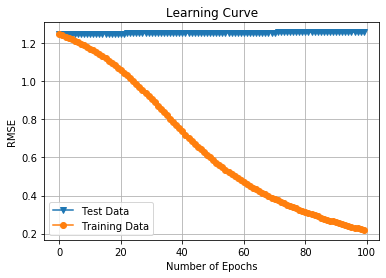

In [42]:
pmf.plot_error()

In [44]:
cf_ratings_train_pmf = pmf.evaluate_test(ratings_df_train,copy = True)
cf_ratings_test_pmf = pmf.evaluate_test(ratings_df_test, copy = True)

36841it [31:36, 19.43it/s] 
9211it [00:26, 348.88it/s]


In [50]:
cf_ratings_test_pmf.columns

Index(['userID', 'itemID', 'rating', 'PMF'], dtype='object')

In [48]:
print("RMSE: ", rmse(cf_ratings_train_pmf['rating'], cf_ratings_train_pmf['PMF']))

RMSE:  0.6527843070452839
